In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

# Na channels: inactivation

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Na channel recordings in the "data/Na_channels" folder

In [2]:
data_folder = "data/Na_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/Na_channels


['data/Na_channels/nav18-iv.abf',
 'data/Na_channels/nav18-ssinact.abf',
 'data/Na_channels/nav18-nav_recovery.abf']

Choose which file you want to analyze and past the file name here:

In [3]:
data_file = 'data/Na_channels/nav18-ssinact.abf'

Now we can load the file and plot the raw data:

Data dimensions (sweeps, channels, timepoints): 
(40, 2, 55000)
sampling freq: 99999.99999999999 Hz


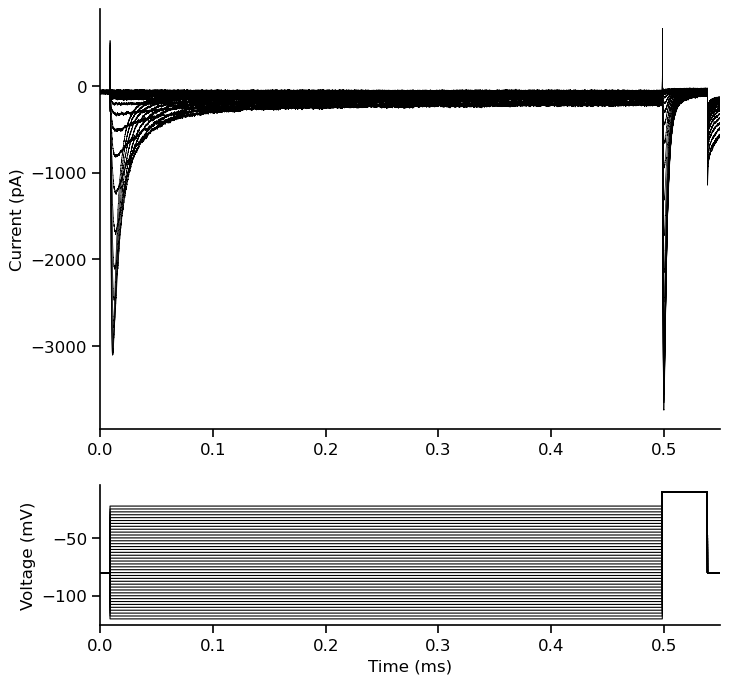

In [4]:
## Extract the sweeps, time and sampling frequency:
sweeps, sweeps_time, sampling_freq = get_sweeps(data_file)

print(f"Data dimensions (sweeps, channels, timepoints): \n{sweeps.shape}")
print(f"sampling freq: {sampling_freq} Hz")

current_traces = sweeps[:, 0, :]
voltage_traces = sweeps[:, 1, :]
ax = plot_traces(sweeps_time, current_traces, voltage_traces)
plt.show()

## 2. Select what you want to measure

### 2.1. Defining the time window

First let's define the relevant time window where we want to measure the currents:

(If you want to save the images, you can do it by clicking on the save icon in the top-right of the image when you hover over it)

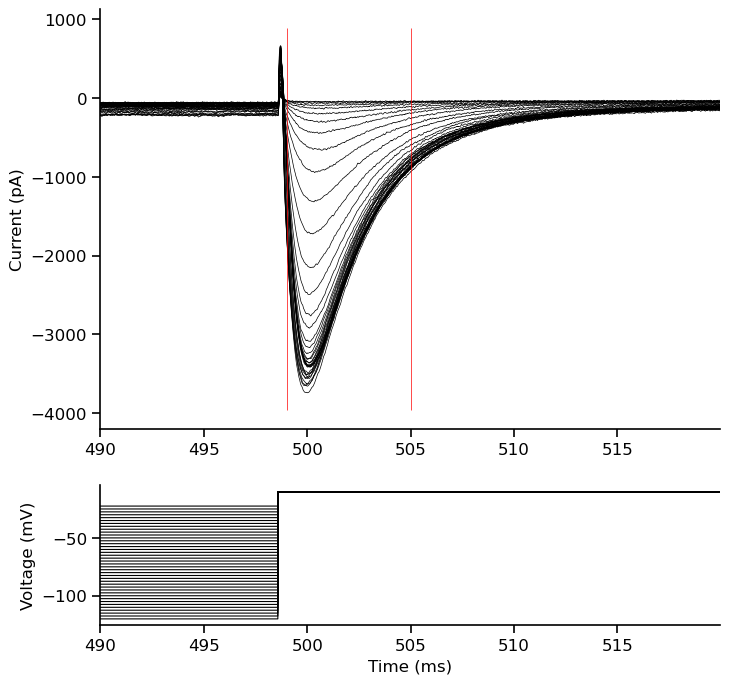

In [5]:
# The start/end time just helps to zoom in on the traces.
start_time = 490  # milliseconds
end_time = 520   # milliseconds, (enter -1 to get the end of the sweep)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 499  # milliseconds
marker_2 = 505    # milliseconds

current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)

ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
plt.show()

### 3.1. Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

In [6]:
# # Measure baseline: you need to specify which part of the trace you want to use for baseline measurement.
# start_time = 0 # milliseconds
# end_time = 0.5 # milliseconds
# measurement_type = 'mean' # Options: 'mean', 'max', 'min'

# baseline_voltage, baseline_current = get_step_measurements(sweeps, sweeps_time, start_time, end_time, sampling_freq, measurement_type)

# # Subtract baseline from the sweeps
# num_traces = sweeps.shape[0]
# for i in range(num_traces):
#     sweeps[i,0] -= baseline_current[i]

### 3.2. Measure currents

Here we will be using the timepoints from the markers we defined above.

Boltzmann Fit parameters:
V_half: -49.895, k: -5.372


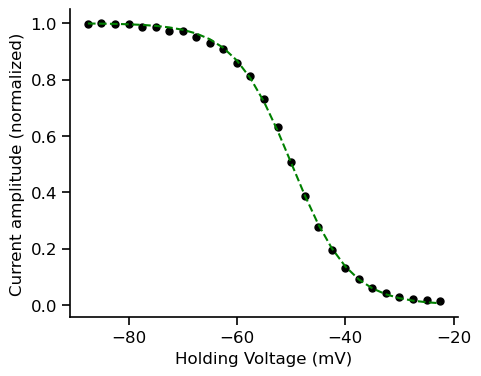

In [7]:
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

_, current_steps = get_step_measurements(sweeps, sweeps_time, 
                                        start_time=marker_1,
                                        end_time=marker_2,
                                        sampling_freq=sampling_freq,
                                        measurement_type=measurement_type)

# Here we want to measure the holding voltages in the first phase of the step protocol.
# Define the timepoint where the voltage is measured
voltage_timepoint = 490 
channel = 1
voltage_steps = sweeps[:, channel, time_to_index(voltage_timepoint, sampling_freq)]

# # Remove bad sweeps
current_steps = current_steps[13:]
voltage_steps = voltage_steps[13:]

# Normalize to the biggest current
current_steps /= np.min(current_steps)  # Normalize current steps to the minimum value

# Plot the normalized current steps against the holding voltages
plt.figure(figsize=(5, 4))
plt.plot(voltage_steps, current_steps, 'o', color='black', markersize=5)
plt.xlabel('Holding Voltage (mV)')
plt.ylabel('Current amplitude (normalized)')

# Optional: fit a Boltzmann function (sigmoid curve) to the data
from scipy.optimize import curve_fit
def boltzmann(V, V_half, k):
    return 1 / (1 + np.exp((V_half - V) / k))
k_guess = -5 # Initial guess for the slope parameter
popt, _ = curve_fit(boltzmann, voltage_steps, current_steps, p0=[np.median(voltage_steps), k_guess])
plt.plot(voltage_steps, boltzmann(voltage_steps, *popt), linestyle='--', color='g', label='Fit')
print("Boltzmann Fit parameters:")
print(f"V_half: {popt[0]:.3f}, k: {popt[1]:.3f}")
